# IS 602 Final Project

## Analyzing spare development capacity under New York's current zoning.

### By Charley Ferrari

In [1]:
import os
import csv
#import Tkinter
#import tkFileDialog
import copy
import re
import pandas as pd
import math
import numpy as np
import re
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import mpl_toolkits.basemap.pyproj as pyproj
%matplotlib inline

import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import *

import warnings
warnings.filterwarnings('ignore')

### Loading in the data

There are errors but that won't matter. I'm either not using those columns or deal with the datatypes

In [2]:
bx = pd.read_csv('bx.csv')
bk = pd.read_csv('bk.csv')
mn = pd.read_csv('mn.csv')
qn = pd.read_csv('qn.csv')
si = pd.read_csv('si.csv')
nyc = pd.concat([bx,bk,mn,qn,si], ignore_index=True)
    

Convert the columns I do need to string (for some reason in the import Pandas didn't deal with blank values too well, and made them a different type.)

In [3]:
nyc['ZoneDist1'] = nyc['ZoneDist1'].astype(str)
nyc['ZoneDist2'] = nyc['ZoneDist2'].astype(str)
nyc['ZoneDist3'] = nyc['ZoneDist3'].astype(str)
nyc['ZoneDist4'] = nyc['ZoneDist4'].astype(str)

In [4]:
#for i in np.arange(0, len(nyc)):
#    nyc['ZoneDist1'][i] = str(nyc['ZoneDist1'][i])
#    nyc['ZoneDist2'][i] = str(nyc['ZoneDist2'][i])
#    nyc['ZoneDist3'][i] = str(nyc['ZoneDist3'][i])
#    nyc['ZoneDist4'][i] = str(nyc['ZoneDist4'][i])

Now to filter the data to what I want. I'm filtering any zone that begins in R, and taking some of the mixed used zones that contain residential uses (hence the '/R'). I'm also removing null values in coordinates. After I do this, I select the columns I need

In [5]:
nycrez = nyc[((nyc['ZoneDist1'].str[:1] == 'R') | (nyc['ZoneDist2'].str[:1] == 'R') | 
             (nyc['ZoneDist2'].str[:1] == 'R') |  (nyc['ZoneDist2'].str[:1] == 'R') | 
             (nyc['ZoneDist1'].str.contains('/R')) | (nyc['ZoneDist2'].str.contains('/R')) |
             (nyc['ZoneDist3'].str.contains('/R')) | (nyc['ZoneDist4'].str.contains('/R'))) &
             (nyc['XCoord'].notnull())]

In [6]:
nycrez = nycrez[['Borough', 'Block', 'Lot', 'CD', 'CT2010', 'CB2010',
                 'Council', 'BldgArea', 'ResArea', 'ResidFAR', 'CommFAR', 
                 'FacilFAR', 'BuiltFAR', 'LotArea', 'XCoord', 'YCoord', 'LandUse',
                 'OwnerName', 'OwnerType', 'Address']]

### Calculations

These are the calculated columns that I'm basing my analysis on. I'm calculating the "leftover FAR" by just subtracting the built FAR from the ResidFAR.

FAR stands for Floor Area Ratio, and is the measure that New York uses to regulate building heights. It's a unique way of either regulating a height directly, or allowing taller buildings in a plot if the entire plot isn't built up. For example, with a FAR of 2, I could use the whole lot to build a 2 story building, or use half the lot to build a 4 story building. If I want to build a taller building, I'm going to have to include some open space.

The Pluto data also uses a unique projection. The definition of the projection the city uses is detailed here: http://www.nyc.gov/html/dcp/pdf/bytes/lion_metadata.pdf

And the spacial reference of the projection is here:
http://spatialreference.org/ref/esri/nad-1983-stateplane-new-york-long-island-fips-3104-feet/

One key thing about this data is that the projection is in feet, while the basemap package that deals with projections only deals with meter coordinates. Before I found this out, I kept on mapping New York City to Northern Quebec...

In [7]:
nycrez['LeftoverResidFAR'] = nycrez['ResidFAR'] - nycrez['BuiltFAR']
nycrez['XCoordMeters'] = nycrez['XCoord'] * 0.3048
nycrez['YCoordMeters'] = nycrez['YCoord'] * 0.3048

There's a huge variation with negative LeftoverResidFARs. My interpretation of this would be that taller buildings were constructed after zoning restrictions were put in place, and grandfathered in. I removed these, since I'm more interested in cases where the used FAR is below the allowed FAR.

In [8]:
# There's a huge variation below 0. I'm guessing zoning restrictions
# in some cases were put in after tall buildings were constructed.

nycrez = nycrez[(nycrez['LeftoverResidFAR'] > 0)]

Now, I could use the pyproj package to convert into latitude and longitude. In the spacial reference, the projection used is this:

http://spatialreference.org/ref/epsg/wgs-84/

In [9]:
nyli = pyproj.Proj("+proj=lcc +lat_1=40.66666666666666 +lat_2=41.03333333333333 +lat_0=40.16666666666666 +lon_0=-74 +x_0=300000 +y_0=0 +ellps=GRS80 +datum=NAD83 +to_meter=0.3048006096012192 +no_defs")
wgs84 = pyproj.Proj("+proj=longlat +ellps=GRS80 +datum=NAD83 +no_defs")



nycrez['Lon'], nycrez['Lat'] = pyproj.transform(nyli, wgs84, nycrez['XCoordMeters'].values, nycrez['YCoordMeters'].values)


### Non Geographic Analysis

Lets look at the distribution of unused FAR:

(array([  4.19168000e+05,   6.62900000e+04,   2.72740000e+04,
          7.49800000e+03,   3.73800000e+03,   1.36500000e+03,
          8.83000000e+02,   6.51000000e+02,   2.75000000e+02,
          1.40000000e+02,   4.60000000e+01,   4.30000000e+01,
          8.00000000e+00,   2.00000000e+01]),
 array([  1.00000000e-02,   8.66428571e-01,   1.72285714e+00,
          2.57928571e+00,   3.43571429e+00,   4.29214286e+00,
          5.14857143e+00,   6.00500000e+00,   6.86142857e+00,
          7.71785714e+00,   8.57428571e+00,   9.43071429e+00,
          1.02871429e+01,   1.11435714e+01,   1.20000000e+01]),
 <a list of 14 Patch objects>)

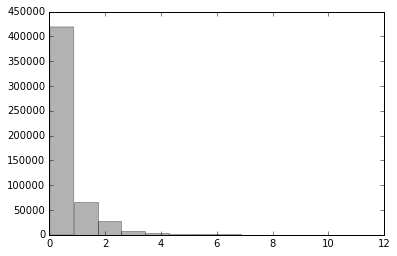

In [10]:


fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)

ax1.hist(nycrez['LeftoverResidFAR'].values, bins=14, color='k', alpha=0.3)

This seemed very heavily skewed towards 0, so I filtered the dataframe:

(array([ 3835.,  1864.,   824.,   999.,   793.,   283.,   219.,   171.,
           33.,    38.,    40.,     5.,     9.,    17.]),
 array([  3.01      ,   3.65214286,   4.29428571,   4.93642857,
          5.57857143,   6.22071429,   6.86285714,   7.505     ,
          8.14714286,   8.78928571,   9.43142857,  10.07357143,
         10.71571429,  11.35785714,  12.        ]),
 <a list of 14 Patch objects>)

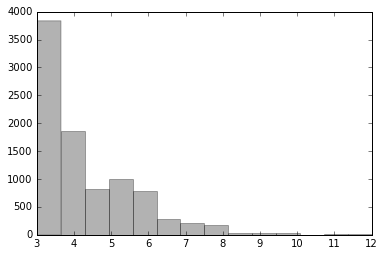

In [11]:

fig2 = plt.figure()
ax2 = fig2.add_subplot(1,1,1)

ax2.hist(nycrez['LeftoverResidFAR'][(nycrez['LeftoverResidFAR'] > 3)].values, bins=14, color='k', alpha=0.3)

It's still pretty skewed, but we can at least get more of an idea of what's going on for the higher values of LeftoverResidFAR.

### Geographic Analysis

For my geographic analysis, I wanted to try to get an idea of where there are pockets of unused FAR. I considered a few strategies in displaying this data. Simply coloring the points by unused FAR, and trying to find a way to "bin" the points to get a heat map were two of my first thoughts. Looking at the distribution of the data however, The detail of the unused FAR would be lost. A vast majority of the properties are built up to (or exceeding) their allowable FAR. 

Because of this, I decided to create a "FARfilter" variable that could be manipulated to change the map. If I were developing this as a tool, I would include this filter as an input, allowing people to change the map in an ad hoc way depending on what they'd like to look at.

As an example below, I set the FARfilter to 4.

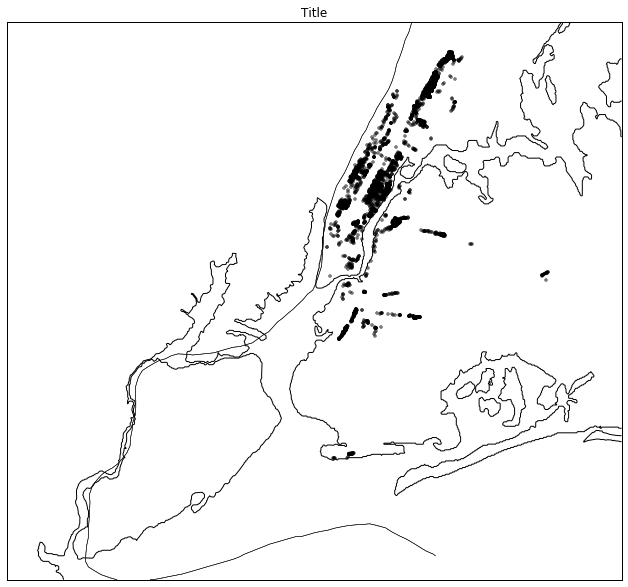

In [12]:
###########################################
#
#
FARfilter = 4
#
#
############################################

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)

ax= axes

lllat=40.481
urlat=40.899
lllon=-74.323
urlon=-73.716

m = Basemap(projection='stere',
                lon_0=(urlon + lllon) / 2,
                lat_0=(urlat + lllat) / 2,
                llcrnrlat=lllat, urcrnrlat=urlat,
                llcrnrlon=lllon, urcrnrlon=urlon,
                resolution='f')
m.drawcoastlines()
m.drawcountries()
m.drawstates()

    
x, y = m(nycrez['Lon'][nycrez['LeftoverResidFAR'] > FARfilter].values, nycrez['Lat'][nycrez['LeftoverResidFAR'] > FARfilter].values)
    
m.plot(x, y, 'k.', alpha=0.5)
ax.set_title('Title')

### Discussion

Coming into this, I expected to see more swaths of land that were below their zoning potential. I expected to be able to draw conclusions about the desireability of a neighborhood and this zoning envelope, point out that there are places out there where developers could build more, but the demand doesn't warrent it. It looks like the fit is tighter than I expected (with a few notable exceptions.)

There are a few areas that might be recognizable from high profile zoning decisions: the upzoning of Midtown East for example. In terms of areas with a larger envelope, I'm surprised to see a lot of prime Manhattan neighborhoods on this map. It suggests that something else must be going on with these neighborhoods. Perhaps higher rates of ownership in apartment buildings discourage developments of those properties.

I came across this article after finishing up this work:

http://www.capitalnewyork.com/article/city-hall/2014/02/8540743/quiet-massive-rezoning-new-york

It's interesting to see the concept I'm arriving at here as the "building envelope." The article looks like zoning changes across the boroughs. While there were some signature upzonings, a lot of the outer boroughs were downzoned to "presereve neighborhood character." The strategy mentioned, downzoning the residential blocks and upzoning commercial arteries, can be seen in the linear patterns in Brooklyn and Queens. 

The strip of envelope in the West Bronx remains a mystery to me. That might be the closest to the more economic zoning envelope I mentioned above. Being from the Bronx, you definitely have seen an increase in development (from the "Bronx is burning" days of vacant lots.) It seems like demand might not have caught up with the capacity in these neighborhoods.

### Plotly Reproduction

Inspired by <a href="https://plot.ly/ipython-notebooks/basemap-maps/">this</a> example, I wanted to try to turn this into a Plotly map.

First, I'll create a new function to filter the original PLUTO dataset:

In [13]:
def filter_far(df,filternum,rounding):
    df = df[df.LeftoverResidFAR >= filternum]
    
    df.loc[:,'LonRound'] = df.Lon.round(rounding)
    df.loc[:,'LatRound'] = df.Lat.round(rounding)
    
    df = df.groupby(['LonRound', 'LatRound']).size()
    
    df = df.reset_index(drop=False)
    
    df.columns = ['LonRound', 'LatRound', 'Count']
    
    return df

Then, I'll use versions of the helper functions from the example. In this case, I'll keep the definition of m I used above rather than the bare minimum basemap. 

In [14]:
lllat=40.55
urlat=40.899
lllon=-74.17
urlon=-73.73

m = Basemap(projection='stere',
                lon_0=(urlon + lllon) / 2,
                lat_0=(urlat + lllat) / 2,
                llcrnrlat=lllat, urcrnrlat=urlat,
                llcrnrlon=lllon, urcrnrlon=urlon,
                resolution='f')

def make_scatter(x,y):
    return Scatter(
        x = x,
        y = y,
        mode = 'lines',
        line = Line(color = "black"),
        name = ' '
    )

def polygons_to_traces(poly_paths, N_poly):
    ''' 
    pos arg 1. (poly_paths): paths to polygons
    pos arg 2. (N_poly): number of polygon to convert
    '''
    traces = []  # init. plotting list 

    for i_poly in range(N_poly):
        poly_path = poly_paths[i_poly]
        
        # get the Basemap coordinates of each segment
        coords_cc = np.array(
            [(vertex[0],vertex[1]) 
             for (vertex,code) in poly_path.iter_segments(simplify=False)]
        )
        
        # convert coordinates to lon/lat by 'inverting' the Basemap projection
        lon_cc, lat_cc = m(coords_cc[:,0],coords_cc[:,1], inverse=True)
        
        # add plot.ly plotting options
        traces.append(make_scatter(lon_cc,lat_cc))
     
    return traces

# Function generating coastline lon/lat traces
def get_coastline_traces():
    poly_paths = m.drawcoastlines().get_paths() # coastline polygon paths
    N_poly = len(poly_paths)
    return polygons_to_traces(poly_paths, N_poly)

# Function generating country lon/lat traces
def get_country_traces():
    poly_paths = m.drawcountries().get_paths() # country polygon paths
    N_poly = len(poly_paths)  # use all countries
    return polygons_to_traces(poly_paths, N_poly)

def get_state_traces():
    poly_paths = m.drawstates().get_paths()
    N_poly = len(poly_paths)
    return polygons_to_traces(poly_paths, N_poly)

Now that I have the map centered, creating the data layers is very similar to the weather example

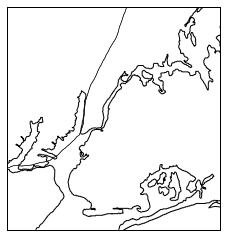

In [15]:
traces_cc = get_coastline_traces()+get_state_traces()

rounding = 2

filtering = 1

nycrezgroup = filter_far(nycrez,filtering,rounding)

# Testing out a ratio measure. Didn't work out too well...

#nycrezgroup0 = filter_far(nycrez,0,rounding)

#nycrezgroup['Ratio'] = nycrezgroup.Count / nycrezgroup0.Count

trace1 = Contour(
    z=nycrezgroup.Count,
    x=nycrezgroup.LonRound,
    y=nycrezgroup.LatRound,
    colorscale="PuBu"
    #zauto=False,  # custom contour levels
    #zmin=-5,      # first contour level
    #zmax=5        # last contour level  => colorscale is centered about 0
)

data = Data([trace1]+traces_cc)

title = u"New York City Zoning Envelope"

axis_style = dict(
    zeroline=False,
    showline=False,
    showgrid=False,
    ticks='',
    showticklabels=False,
)

layout = Layout(
    title=title,
    showlegend=False,
    hovermode="closest",        # highlight closest point on hover
    xaxis=XAxis(
        axis_style,
        range=[nycrezgroup.LonRound.ix[0],nycrezgroup.LonRound.tail(1)]  # restrict y-axis to range of lon
    ),
    yaxis=YAxis(
        axis_style,
    ),
    autosize=False,
    width=1000,
    height=1000,
)

Lastly, I'll plot the results

In [16]:
fig = Figure(data=data, layout=layout)

py.iplot(fig, filename="contour_map", width=1000)

This provides another view of the information presented in the scatter plot. Since the scatter plot is so dense, this gives more of an idea of where buildings with unused FAR are clustered. The coriders in Brooklyn for example have dense clusters of these buildings. This supports the hypothesis that the unused FAR here is mainly due to rezoning, while the lighter clusters in the Bronx may just be natural areas of underdevelopment.

### Adding Interactivity with Restyle

Ideally I would like a user to be able to filter the results by the number of floors available for development. This would help to further illustrate the nature of the zoning envelope. Is it only possible to add minor additions to buildings, or are major neighborhood changes possible?

I'll have to pre-process the data a bit to make this possible. I'll create 10 categories of number of unused floors (with 10 being "10 or more"), and provide counts for each of them (making sure to reindex so the map is always sized properly.)

In [17]:
rounding = 2

nyctotcount = filter_far(nycrez,1,rounding)

nyctotcount['filtering'] = 1

nycfilterref = nycrez[nycrez.LeftoverResidFAR >= 1]
nycfilterref.loc[:,'LonRound'] = nycfilterref.Lon.round(rounding)
nycfilterref.loc[:,'LatRound'] = nycfilterref.Lat.round(rounding)

nycfilterref = nycfilterref.groupby(['LonRound', 'LatRound']).size()


for filtering in np.arange(2,11):
    nyctotcountap = nycrez[nycrez.LeftoverResidFAR >= filtering]
    nyctotcountap = nyctotcountap[nyctotcountap.LeftoverResidFAR >= filtering]
    nyctotcountap.loc[:,'LonRound'] = nyctotcountap.Lon.round(rounding)
    nyctotcountap.loc[:,'LatRound'] = nyctotcountap.Lat.round(rounding)
    
    nyctotcountap = nyctotcountap.groupby(['LonRound', 'LatRound']).size()
    
    nyctotcountap = nyctotcountap.reindex(index = nycfilterref.index)
    
    nyctotcountap[nyctotcountap.isnull()] = 0
    
    nyctotcountap = nyctotcountap.reset_index(drop=False)
    nyctotcountap.columns = ['LonRound', 'LatRound', 'Count']
    
    nyctotcountap['filtering'] = filtering
    
    nyctotcount = nyctotcount.append(nyctotcountap)

In order to get this widget to work, I'll follow the example in <a href="http://nbviewer.ipython.org/gist/chriddyp/9827cb5086cfab8da092/Pandas%20Widget%20-%20Time%20Series,%20Search,%20and%20Filtering.ipynb">this</a> notebook. Meaning, I'll import the graph as a 

In [18]:
from ipywidgets import *

from plotly.widgets import GraphWidget

from IPython.display import display, clear_output


<IPython.core.display.Javascript object>

In [19]:

g = GraphWidget('https://plot.ly/~charleyferrari/24')
#x = y = np.arange(-5,5,0.1)
#yt = x[:,np.newaxis]

class z_data:
    def __init__(self):
        self.z = nyctotcount.loc[nyctotcount.filtering == 1,'Count']
    
    def on_z_change(self, name, old_value, new_value):
        self.z = nyctotcount.loc[nyctotcount.filtering == new_value,'Count']
        self.replot()
        
    def replot(self):
        g.restyle({ 'z': [self.z] })

z_slider = widgets.FloatSlider(min=1,max=10,value=1,step=1)
z_slider.description = 'Number of Floors'
z_slider.value = 1

z_state = z_data()
z_slider.on_trait_change(z_state.on_z_change, 'value')

In [20]:

display(z_slider)
display(g)

#g.restyle({'z' : nyctotcount.loc[nyctotcount.filtering == 1,'Count']})